## Goodreads Book Recommender

#### Introduction

This notebook generates book recommendations using two methods: collabortive filtering based on reader similarity and collaborative filtering based on predicted book ratings. The former uses KNN while the latter uses two forms of matrix factorization - first by singular value decomposition (SVD) and next by gradient descent using alternating least squares (ALS). 

Book and user ratings data come from the [Goodreads Book Graph Datasets](https://github.com/MengtingWan/goodreads]) produced by Mengting Wan, Rishabh Misra, Ndapa Nakashole, and Julian McAuley at UCSD. It has been imported, cleaned, and preprocessed in [00_prep_goodreads_data.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/00_prep_goodreads_data.ipynb). Genres, which are important for filtering recommendations but missing from the UCSD dataset, are inferred by topic modeling via latent dirichlet allocation (LDA) on book descriptions in [01_infer_genres.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/01_infer_genres.ipynb).

The target reader, for whom recommendations are being made in this notebook, is myself. To substitute your own Goodreads data and get personalized recommendations, go to the [Import/Export page](https://www.goodreads.com/review/import) on your Goodreads profile, download your books, and save as ```./data/goodreads_library_export.csv``` 

#### Contents

[Part 0: Preprocessing](#part-0-preprocessing)
- [0.1 - Load and Prepare Data](#01---load-and-prepare-data)
- [0.1 - Write Functions to Process Recommendations](#02---write-functions-to-process-recommendations)

[Part 1: Collaborative Filtering Based on Reader Similarity with KNN](#part-1---collaborative-filtering-based-on-reader-similarity-with-knn)
- [1.1 - Find Similar Readers](#11---find-similar-readers)
- [1.2 - Generate Recommendations](#12---generate-recommendations)


[Part 2: Collaborative Filtering Based on Predicted Ratings with Matrix Factorization](#part-2---collaborative-filtering-based-on-predicted-ratings-with-matrix-factorization)
- [2.1 - Factorize User-Rating Matrix with SVD](#21---factorize-user-rating-matrix-with-svd)
- [2.2 - Generate Recommendations by Predicting Ratings](#22---generate-recommendations-by-predicting-ratings)
- [2.3 - Matrix Factorization with Gradient Descent](#23-matrix-factorization-with-gradient-descent)

## Part 0: Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
from IPython.display import display
from scipy.sparse.linalg import svds

### 0.1 - Load and Prepare Data

In [2]:
# Load df_books and genres
wd = os.getcwd()
df_books = pd.read_csv(wd + "/data/goodreads_books.csv")
df_inferred_genres = pd.read_csv(wd + "/data/inferred_genres.csv")
genre_descriptors = pd.read_csv(wd + "/data/inferred_genre_top_words.csv")

# Join genres to books
df_books = pd.merge(df_books, df_inferred_genres, how="left", on="book_id")

# Filter out kids books
df_books = df_books[df_books.loc[:,"children":"comic"].sum(axis=1) < 2]

In [3]:
# Load sparse_reviews from file
df_reviews = sparse.load_npz(wd + "/data/user_reviews.npz")

# Load user (rows) and book (cols) indices
user_index = pd.read_csv(wd + "/data/user_index_for_sparse_matrix.csv").rename(columns={"0":"user_id"})
book_index = pd.read_csv(wd + "/data/book_index_for_sparse_matrix.csv").rename(columns={"0":"book_id"})

In [4]:
# Create df_reviews that is less sparse than original
in_df_books = book_index["book_id"].isin(df_books["book_id"])
book_index = book_index[in_df_books].reset_index().drop("index", axis=1)
df_reviews = df_reviews[:, in_df_books]

In [5]:
# Load my goodreads history
my_books = pd.read_csv(wd + "/data/goodreads_library_export.csv")

# Filter to books I've rated
my_books = my_books[["Book Id", "My Rating", "Title"]]\
    .rename(columns={"Book Id":"book_id", "My Rating":"rating", "Title":"title"}).query("rating > 0")
print(f"Target reader ratings: {my_books.shape[0]}")

# Reformat to fit sparse matrix
my_books_1 = pd.merge(
                my_books, df_books[["book_id", "title"]], 
                how="left", on="book_id", suffixes=["_mb","_dfb"]
            )
my_books_id_match = my_books_1[~my_books_1["title_dfb"].isna()]
print(f"Matching on book_id: {my_books_id_match.shape[0]}")

my_books_2 = pd.merge(
    my_books_1[my_books_1["title_dfb"].isna()], df_books[["book_id", "title"]], 
    how="left", left_on="title_mb", right_on="title", suffixes=["_mb","_dfb"]
    )
my_books_match_on_title = my_books_2[~my_books_2["title"].isna()]
print(f"Matching on title: {my_books_match_on_title.shape[0]}")

my_books_id_match = my_books_id_match[["book_id", "rating", "title_dfb"]]\
                        .rename(columns={"title_dfb":"title"})
my_books_match_on_title = my_books_match_on_title[["book_id_dfb", "rating", "title"]]\
                        .rename(columns={"book_id_dfb":"book_id"})

my_books_3 = pd.concat([my_books_id_match, my_books_match_on_title])
my_books_3 = my_books_3.drop_duplicates(subset="book_id")
print(f"Total matches: {my_books_3.shape[0]}, {(my_books_3.shape[0] / my_books.shape[0]):.2%} of total")

my_books_4 = pd.merge(book_index, my_books_3, how="left", on="book_id").fillna(0.)
my_books = np.array(my_books_4["rating"]).reshape(1,-1)

# Add to sparse matrix
df_reviews = sparse.vstack([df_reviews, my_books])
df_reviews = sparse.csr_matrix(df_reviews)

# Normalize reviews within readers for KNN
norm = Normalizer()
df_reviews_norm = norm.fit_transform(df_reviews) 

Target reader ratings: 168
Matching on book_id: 28
Matching on title: 68
Total matches: 96, 57.14% of total


In [6]:
# Set target reader to make recommendations for
target = df_reviews.shape[0] - 1

#### 0.2 - Write Functions to Process Recommendations

In [39]:
# Function to use KNN to find similar users
def find_neighbors(n_neighbors, target_user, ratings_df, ind_books, books):

    # Instantiate KNN
    n_neighbors = n_neighbors

    nn_model = NearestNeighbors(
        metric="cosine",
        algorithm="auto",
        n_neighbors=n_neighbors,
        n_jobs=-1
    )

    # Fit to sparse matrix
    nn_model.fit(ratings_df)

    # Feed in user and get neighbors and distances
    reader = ratings_df[target,:].toarray()
    dists, neighbors = nn_model.kneighbors(reader, return_distance=True)

    similar_users = pd.DataFrame(
        [pd.Series(neighbors.reshape(-1)), pd.Series(dists.reshape(-1))]).T.rename(
            columns={0:"user", 1:"distance"}
    )

    # Get all books read by similar users
    book_ind = []
    book_rat = []
    uid = []
    target_user_books = []
    target_user_book_rat = []
    for nt in similar_users.itertuples():
        user = ratings_df[int(nt.user),:].toarray()
        book_inds = np.where(user[0] > 0)[0]
        ratings = user[0][np.where(user[0] > 0)[0]]
        for i in range(len(book_inds)):        
            book_ind.append(book_inds[i])
            book_rat.append(ratings[i])
            uid.append(nt.user)    
            if nt.distance < 0.000000001:
                target_user_books.append(book_inds[i])
                target_user_book_rat.append(ratings[i])

    neighbor_user_ratings = pd.DataFrame([uid, book_ind, book_rat]).T.rename(
                                columns={0:"uid",1:"book_index",2:"user_rating"}
                            )

    # Join overall rating for each book
    neighbor_user_ratings = pd.merge(
                                ind_books.reset_index(), neighbor_user_ratings, 
                                how="inner", left_on="index", right_on="book_index"
                            )
    neighbor_user_ratings = pd.merge(neighbor_user_ratings, books, how="inner", on="book_id")

    # Filter out books target reader has already read
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["book_index"].isin(target_user_books)]
    neighbor_user_ratings.drop(["index"], axis=1, inplace=True)

    # Filter out later volumes in series using regex pattern
    regex1 = r"#(?:[2-9]|[1-9]\d+)"
    regex2 = r"Vol. (?:[0-9]|[1-9]\d+)"
    regex3 = r"Volume (?:[0-9]|[1-9]\d+)"
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex3)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains("#1-")]

    # View target user's ratings
    target_user_ratings = pd.DataFrame(
                            [target_user_books, target_user_book_rat]).T.rename(
                                columns={0:"book_index",1:"user_rating"}
                        )
    target_user_ratings = pd.merge(
                            ind_books.reset_index(), target_user_ratings,
                            how="inner", left_on="index", right_on="book_index"
                        )
    target_user_ratings = pd.merge(target_user_ratings, books, how="inner", on="book_id")    

    return neighbor_user_ratings, target_user_ratings, dists

In [8]:
# Function to show top recs for each genre
def show_top_recs_by_genre(
        target, others, preds=None, how=["KNN", "MF"], whose_genres=["target", "neighbors"], 
        n_genres=5, min_score=3.9, min_ratings=400, n_recs=15, write_to_excel=False):

    if whose_genres == "target":
        genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    else:
        genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))    
    
    genres = []
    results = []
    # Loop through genres in descending relevance order and print top recs
    for genre in genre_ranking.index[0:n_genres]:        
        
        g = float(genre[6:])
        if how == "KNN":
            highest_rated_recs_genre = others.query("main_genre == @g")\
                .groupby(["title", "avg_rating", "ratings_count", "year", "url"])["book_id"]\
                .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)
        
        elif how == "MF":
            highest_rated_recs_genre = preds.query("main_genre == @g")\
            .sort_values(by="predicted_rating", ascending=False)                

        highest_rated_recs_genre = highest_rated_recs_genre.query(
                                        "ratings_count > @min_ratings & avg_rating > @min_score"
                                    )

        # Print genre name and descriptor
        for nt in genre_descriptors.itertuples():
            genre_rep = genre.replace("_"," ")
            if nt.genre_string[0:len(f"{genre}:")] == f"{genre_rep}:":
                gs = (nt.genre_string)
        
        genres.append(gs)
        results.append(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(50))

        print(gs)
        display(highest_rated_recs_genre[["title", "avg_rating", "ratings_count", "url"]].head(n_recs))
        print("_____\n")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        writer.close

In [9]:
# Functions to show top rated and most popular among similar readers
def neighbors_most_popular(others, n=10, min_ratings=1000, min_score=3.8, write_to_excel=False):
    
    popular_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["book_id", "avg_rating"], ascending=False)\
        .nlargest(n, "book_id").rename(columns={"book_id":"percent_similar_users_read"})

    popular_recs["percent_similar_users_read"] = (popular_recs["percent_similar_users_read"] / 
                                                    others["uid"].nunique()).map('{:.1%}'.format)
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
                
        writer.close

    return popular_recs[["title","avg_rating","ratings_count","year","percent_similar_users_read","url"]]


def neighbors_top_rated(others, n=10, min_ratings=1000, min_score=3.8, write_to_excel=False):

    highest_rated_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "ratings_count", "year","url"])["book_id"]\
        .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
        .nlargest(n, "avg_rating").drop(columns="book_id")
    
    # Write to excel if keyword set
    path = (wd + "/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
                
        writer.close

    return highest_rated_recs

In [10]:
# Function to plot neighbors' and target's top genres
def plot_top_genres(others, target):

    # Get genre rankings for target and neighbors
    target_genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0)\
                                            .sort_values(ascending=False)).rename(columns={0:"target"})
    target_genre_ranking = target_genre_ranking.div(target_genre_ranking.sum(axis=0), axis=1)

    neighbor_genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0)\
                                            .sort_values(ascending=False)).rename(columns={0:"neighbor"})
    neighbor_genre_ranking = neighbor_genre_ranking.div(neighbor_genre_ranking.sum(axis=0), axis=1)

    genre_rankings = pd.merge(
            target_genre_ranking, neighbor_genre_ranking, left_index=True, right_index=True
            ).reset_index()

    # Plot target genre pref
    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(
        data=genre_rankings,
        y='index',
        x='target',
        s=150,
        edgecolors='black',
        linewidths = 0.75,
        label='Target Reader',
        zorder=2,
        )

    # Plot neighbors genre pref
    sns.scatterplot(
        data=genre_rankings,
        y='index',
        x='neighbor',
        label='Similar Readers',
        s=150,
        zorder=3
        )

    # Iterate through each genre and plot line connecting 2 points
    for ind in list(genre_rankings['index']):
    
        # Plot line connecting points
        plt.plot([genre_rankings[genre_rankings['index']==ind]['target'],
                    genre_rankings[genre_rankings['index']==ind]['neighbor']],
                    [ind, ind],
                    color='#565A5C',
                    alpha=0.9,                    
                    linestyle=(0, (1,1)),
                    linewidth=2.5,
                    zorder=1
                    )

    # Set chart details
    plt.legend(bbox_to_anchor=(1,1), loc="upper left", borderpad=1)
    ax.yaxis.grid(True, alpha=0.4) # Create y gridlines
    ax.xaxis.grid(True, alpha=0.4) # Create x gridlines
    plt.xlabel("Genre preference")
    plt.ylabel(None)
    plt.title('Top Genres for Target Reader and Similar Readers', fontsize=14)
    plt.show()

## Part 1 - Collaborative Filtering Based on Reader Similarity with KNN

In this section, we use K-Nearest Neighbors (KNN) to find the readers most similar to our target reader. Each reader's ratings on all books in the dataset are encoded as vectors where unread books are given a value of 0. We use cosine similarity to find the users whose ratings are most similar to the target and then filter among their books to find the most popular and highest rated.

### 1.1 - Find Similar Readers

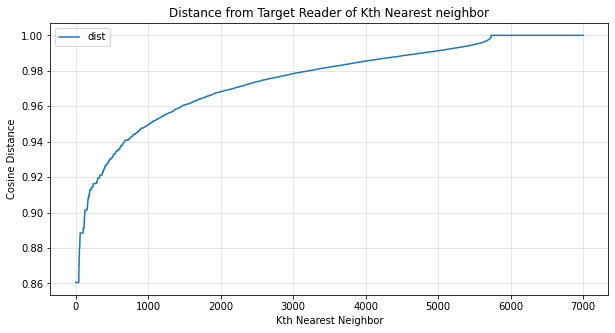

In [72]:
n, t, dists = find_neighbors(10000, target, df_reviews_norm, book_index, df_books)

# Plot distance by kth closest neighbor
fig, ax = plt.subplots(figsize=(10,5))
pd.DataFrame(dists.T).rename(columns={0:"dist"})[1:7000].plot(ax=ax)
plt.title("Distance from Target Reader of Kth Nearest neighbor")
plt.xlabel("Kth Nearest Neighbor")
plt.ylabel("Cosine Distance")
ax.yaxis.grid(True, alpha=0.4) # Create y gridlines
ax.xaxis.grid(True, alpha=0.4) # Create x gridlines
plt.show()

In [74]:
# Perform KNN on user rating matrix
sm_neighborhood_ratings, target_user_ratings, d = find_neighbors(
                                                        200, target, df_reviews_norm, book_index, df_books)

# Find med number of similar users than before to get broader pool of potentially relevant books
med_neighborhood_ratings, target_user_ratings, d = find_neighbors(
                                                    750, target, df_reviews_norm, book_index, df_books)

# Find larger number of similar users 
lg_neighborhoodhood_ratings, target_user_ratings, d = find_neighbors(
                                                        1500, target, df_reviews_norm, book_index, df_books)

print(f"Small neighborhood contains {sm_neighborhood_ratings['book_index'].nunique()} books")
print(f"Medium neighborhood contains {med_neighborhood_ratings['book_index'].nunique()} books")
print(f"Large neighborhood contains {lg_neighborhoodhood_ratings['book_index'].nunique()} books")

Small neighborhood contains 232 books
Medium neighborhood contains 1735 books
Large neighborhood contains 6193 books


<a id='Part1.2'></a>
### 1.2 - Generate Recommendations

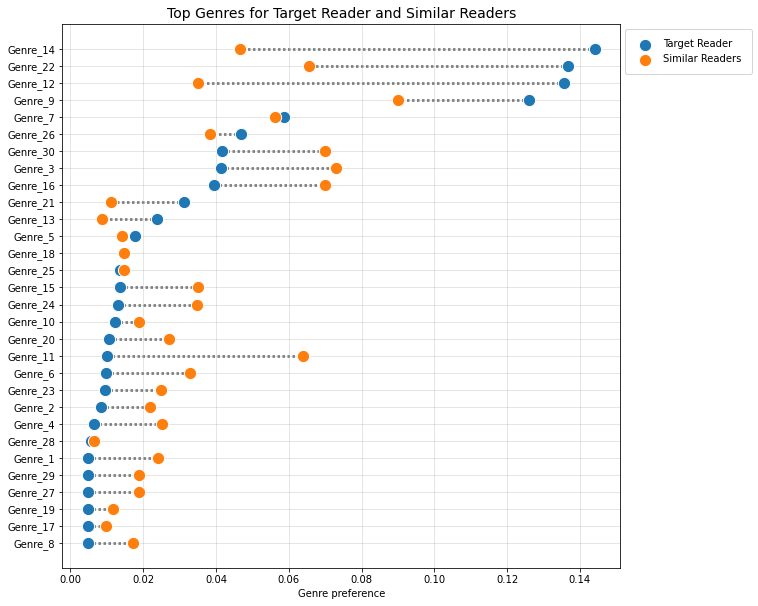

In [75]:
# Show top genres
plot_top_genres(sm_neighborhood_ratings, target_user_ratings)

In [76]:
# View most popular books among neighbors
neighbors_most_popular(sm_neighborhood_ratings, 15, min_ratings=400, write_to_excel=False)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
110,"Wool Omnibus (Silo, #1)",4.24,83601.0,2012,2.5%,https://www.goodreads.com/book/show/13453029-w...
103,The Yellow Wall-Paper,4.11,45971.0,1996,1.7%,https://www.goodreads.com/book/show/286957.The...
8,Anything You Can Do,3.98,7816.0,2017,1.7%,https://www.goodreads.com/book/show/34044126-a...
9,Assata: An Autobiography,4.47,11057.0,1999,0.8%,https://www.goodreads.com/book/show/100322.Assata
82,The Girl with Seven Names: A North Korean Defe...,4.45,8293.0,2015,0.8%,https://www.goodreads.com/book/show/25362017-t...
28,"Deep: Freediving, Renegade Science, and What t...",4.40,1144.0,2014,0.8%,https://www.goodreads.com/book/show/18222705-deep
78,The Complete Conversations with God,4.38,3395.0,1998,0.8%,https://www.goodreads.com/book/show/15016.The_...
3,A Farewell to Mars: An Evangelical Pastor's Jo...,4.35,573.0,2014,0.8%,https://www.goodreads.com/book/show/18281678-a...
10,Auschwitz and After,4.35,758.0,1997,0.8%,https://www.goodreads.com/book/show/339757.Aus...
20,Bobby Singer's Guide to Hunting,4.32,1942.0,2011,0.8%,https://www.goodreads.com/book/show/11804728-b...


In [77]:
# View highest rated books among similar readers
neighbors_top_rated(sm_neighborhood_ratings, 15, min_ratings=400, write_to_excel=False)

,title,avg_rating,ratings_count,year,url
9,Assata: An Autobiography,4.47,11057.0,1999,https://www.goodreads.com/book/show/100322.Assata
82,The Girl with Seven Names: A North Korean Defe...,4.45,8293.0,2015,https://www.goodreads.com/book/show/25362017-t...
28,"Deep: Freediving, Renegade Science, and What t...",4.40,1144.0,2014,https://www.goodreads.com/book/show/18222705-deep
78,The Complete Conversations with God,4.38,3395.0,1998,https://www.goodreads.com/book/show/15016.The_...
3,A Farewell to Mars: An Evangelical Pastor's Jo...,4.35,573.0,2014,https://www.goodreads.com/book/show/18281678-a...
10,Auschwitz and After,4.35,758.0,1997,https://www.goodreads.com/book/show/339757.Aus...
20,Bobby Singer's Guide to Hunting,4.32,1942.0,2011,https://www.goodreads.com/book/show/11804728-b...
60,"Red Sister (Book of the Ancestor, #1)",4.32,5784.0,2017,https://www.goodreads.com/book/show/25895524-r...
53,New Seeds of Contemplation,4.31,913.0,2007,https://www.goodreads.com/book/show/1145854.Ne...
63,"Scythe (Arc of a Scythe, #1)",4.30,13000.0,2016,https://www.goodreads.com/book/show/28954189-s...


In [78]:
# View highest rated books by each of the top genres
show_top_recs_by_genre(
    target=target_user_ratings, 
    others=sm_neighborhood_ratings, 
    how="KNN", 
    whose_genres="target", 
    n_genres=5, 
    min_score=3.9, 
    min_ratings=400, 
    n_recs=15,
    write_to_excel=False
)

Genre 14: ['political', 'history', 'world', 'economic', 'government', 'global', 'politics', 'social', 'country', 'financial']


,title,avg_rating,ratings_count,url
6,Narconomics: How to Run a Drug Cartel,4.14,2268.0,https://www.goodreads.com/book/show/25159062-n...
8,Shades of Grey,4.14,23122.0,https://www.goodreads.com/book/show/2113260.Sh...
2,Capital in the Twenty-First Century,4.02,13494.0,https://www.goodreads.com/book/show/18736925-c...
3,Don't Think of an Elephant! Know Your Values a...,3.96,3360.0,https://www.goodreads.com/book/show/13455.Don_...
7,One Child: The Story of China's Most Radical E...,3.92,1108.0,https://www.goodreads.com/book/show/23719361-o...


_____

Genre 22: ['history', 'poem', 'text', 'introduction', 'writing', 'science', 'translation', 'literature', 'essay', 'modern']


,title,avg_rating,ratings_count,url
7,"Notes from Underground, White Nights, The Drea...",4.17,66680.0,https://www.goodreads.com/book/show/17876.Note...
3,Invisible Planets: Contemporary Chinese Scienc...,4.13,650.0,https://www.goodreads.com/book/show/28220730-i...
10,The Dune Encyclopedia,4.08,3343.0,https://www.goodreads.com/book/show/870294.The...
9,Surprised by Scripture: Engaging Contemporary ...,4.06,618.0,https://www.goodreads.com/book/show/18651961-s...
16,When Elephants Weep: The Emotional Lives of An...,4.04,3744.0,https://www.goodreads.com/book/show/167224.Whe...
2,How to Read a Book: The Classic Guide to Intel...,4.00,9478.0,https://www.goodreads.com/book/show/567610.How...


_____

Genre 12: ['alien', 'planet', 'world', 'human', 'space', 'war', 'galaxy', 'race', 'ship', 'humanity']


,title,avg_rating,ratings_count,url
1,Dragon's Egg,4.14,4328.0,https://www.goodreads.com/book/show/263466.Dra...


_____

Genre 9: ['war', 'history', 'account', 'family', 'year', 'young', 'world', 'time', 'memoir', 'portrait']


,title,avg_rating,ratings_count,url
0,Assata: An Autobiography,4.47,11057.0,https://www.goodreads.com/book/show/100322.Assata
14,The Girl with Seven Names: A North Korean Defe...,4.45,8293.0,https://www.goodreads.com/book/show/25362017-t...
1,Auschwitz and After,4.35,758.0,https://www.goodreads.com/book/show/339757.Aus...
7,"Dear Leader: Poet, Spy, Escapee—A Look Inside ...",4.29,2732.0,https://www.goodreads.com/book/show/20736640-d...
18,We Wish to Inform You That Tomorrow We Will Be...,4.29,19564.0,https://www.goodreads.com/book/show/11472.We_W...
13,Stars Between the Sun and Moon: One Woman's Li...,4.16,451.0,https://www.goodreads.com/book/show/25420166-s...
5,Clementine: The Life of Mrs. Winston Churchill,4.08,1042.0,https://www.goodreads.com/book/show/24611873-c...
6,Curfewed Night,3.94,1820.0,https://www.goodreads.com/book/show/6047138-cu...
11,No One Cares About Crazy People: The Chaos and...,3.92,834.0,https://www.goodreads.com/book/show/30363776-n...
3,Blue Pills: A Positive Love Story,3.91,3154.0,https://www.goodreads.com/book/show/1390442.Bl...


_____

Genre 7: ['film', 'music', 'funny', 'movie', 'hilarious', 'year', 'memoir', 'world', 'time', 'star']


,title,avg_rating,ratings_count,url
10,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,https://www.goodreads.com/book/show/5544.Surel...
4,It Gets Worse: A Collection of Essays,4.27,520.0,https://www.goodreads.com/book/show/27276226-i...
13,You Deserve a Drink: Boozy Misadventures and T...,4.21,4938.0,https://www.goodreads.com/book/show/23281915-y...
11,The Real James Herriot: A Memoir of My Father,4.17,3791.0,https://www.goodreads.com/book/show/38737.The_...
1,Dorothy Parker: What Fresh Hell Is This?,4.11,2429.0,https://www.goodreads.com/book/show/181120.Dor...
12,The Unpersuadables: Adventures with the Enemie...,4.00,580.0,https://www.goodreads.com/book/show/18114379-t...
0,Bad Feminist,3.91,43988.0,https://www.goodreads.com/book/show/18813642-b...


_____



## Part 2 - Collaborative Filtering Based on Predicted Ratings with Matrix Factorization

In sections [2.1](#21---factorize-user-rating-matrix-with-svd) and [2.2](#22---generate-recommendations-by-predicting-ratings) we use singular value decomposition (SVD) to factorize the user-rating matrix generated from the 1500 most similar readers to the target reader, as determined by KNN. SVD decomposes our $m * n$ user-rating matrix $R$ into 3 smaller matrices: $$R = U \Sigma \mathbf{V}^\top$$ where $U$, the left singular vectors, represents an $m * k$ embedding space of user features and $\mathbf{V}^\top$, the right singular vectors, represents a $k * n$ embedding of book features. Estimated ratings come from multiplying the decomposed matrices together to approximate $R$. 

The advantage of SVD is its simplicity and computational efficiency. The disadvantage is that it requires unseen ratings to be encoded as 0 and therefore all predicted ratings on unread books are near zero rather than more realistic values. 

-----

In section [2.3](#23-matrix-factorization-with-gradient-descent) we use gradient descent to train user and book embedding matrices $P$ and $Q$. We minimize the loss function: $$L = (r_{ij} - \sum_{k=1}^{K} p_{ik}q_{kj})^2 + \frac{\beta}{2}\sum_{k=1}^{K}(||P||^2 + ||Q||^2)$$ for all $r_{ij} > 0$ using alternating least squares. After training, we reconstruct $R$ matrix by multiplyting $P * Q$. See [here](http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/) for a helpful description of th math.

The advantage of gradient descent is that we can train the model on nonzero ratings (i.e. only for books users have actually rated) and apply it to unread books, which yields realistic rating predictions. The downside is that it is computationally very expensive. Larger user-raing $R$ matrices have exponentially more values than smaller ones, so there is a limit to how many nearest neighbors we can use to generate the full set of book ratings to consider. 

#### 2.1 - Factorize User-Rating Matrix with SVD

In [79]:
# Choose neighborhood size for SVD
svd_neighborhood_ratings = med_neighborhood_ratings

In [95]:
# Get unique users and books to slice df_reviews
svd_neighbor_index = svd_neighborhood_ratings["uid"].unique()
svd_neighbor_index = np.append(svd_neighbor_index, target)
svd_neighbor_book_index = svd_neighborhood_ratings["book_index"].unique()
svd_neighbor_book_index = np.append(svd_neighbor_book_index, target_user_ratings["book_index"].unique())

print(f"Neighborhood contains {svd_neighbor_book_index.shape[0]} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, svd_neighbor_book_index]
R = R[svd_neighbor_index, :]

Neighborhood contains 1831 books


In [109]:
# Decompose user ratings matrix R with SVD
U, sigma, Vt = svds(R, k=30)
sigma = np.diag(sigma)

# Convert to sparse matrix
U = sparse.csr_matrix(U)
sigma = sparse.csr_matrix(sigma)
Vt = sparse.csr_matrix(Vt)

#### 2.2 - Generate Recommendations by Predicting Ratings

In [110]:
# Get predictions
all_user_predicted_ratings = U.dot(sigma) @ Vt
df_preds = pd.DataFrame(
                all_user_predicted_ratings.toarray(), columns=svd_neighbor_book_index, index=svd_neighbor_index
                ).reset_index()

In [21]:
# Get top recs from predictions
def get_recs(preds, target_reader, book_ind, books, write_to_excel=False):
    
    target_pred_books = preds[preds["index"] == target_reader].columns[1:]
    target_pred_ratings = preds[preds["index"] == target_reader].values[0][1:]

    # Put into df with relevant info from df_books
    top_preds = pd.DataFrame({"book_index":target_pred_books, "predicted_rating":target_pred_ratings})\
                    .sort_values(by="predicted_rating", ascending=False)\
                    .merge(book_ind.reset_index(), left_on="book_index", right_on="index")\
                    .merge(
                        books[["book_id", "title", "avg_rating", "ratings_count", "year", "main_genre","url"]],
                        on="book_id"
                    )\
                    .drop(columns=["index", "book_id"])

    # Filter out already read books
    top_preds = top_preds[~top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]
    top_preds.drop(["book_index"], axis=1, inplace=True)

    if write_to_excel == True:
        # Write to excel
        path = wd + "/data/book_recs.xlsx"
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                top_preds.query("avg_rating > 3.9").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        writer.close

    return top_preds

In [111]:
# View books with highest target user predicted score
top_preds = get_recs(df_preds, target, book_index, df_books, write_to_excel=False)
top_preds[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
                .query("avg_rating > 4.15 & ratings_count > 750").head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
97,Labyrinths: Selected Stories and Other Writings,4.46,0.146358,20553.0,1964,https://www.goodreads.com/book/show/17717.Laby...
101,Mountains Beyond Mountains: The Quest of Dr. P...,4.21,0.122983,53936.0,2003,https://www.goodreads.com/book/show/10235.Moun...
102,"I, Robot (Robot, #0.1)",4.17,0.121467,2235.0,2004,https://www.goodreads.com/book/show/76684.I_Robot
104,The Power of Positive Dog Training (Howell ref...,4.27,0.121224,886.0,2001,https://www.goodreads.com/book/show/215767.The...
135,"Promise of Blood (Powder Mage, #1)",4.16,0.093825,22179.0,2013,https://www.goodreads.com/book/show/15790883-p...
136,"Red Sister (Book of the Ancestor, #1)",4.32,0.093825,5784.0,2017,https://www.goodreads.com/book/show/25895524-r...
146,El perseguidor,4.20,0.088645,1340.0,1958,https://www.goodreads.com/book/show/2137094.El...
160,The Operator: Firing the Shots that Killed Osa...,4.42,0.085258,833.0,2017,https://www.goodreads.com/book/show/34127824-t...
194,Have a Little Faith: a True Story,4.16,0.063077,60867.0,2009,https://www.goodreads.com/book/show/1255781.Ha...
198,The Complete Stories and Poems,4.37,0.061910,161550.0,1984,https://www.goodreads.com/book/show/23919.The_...


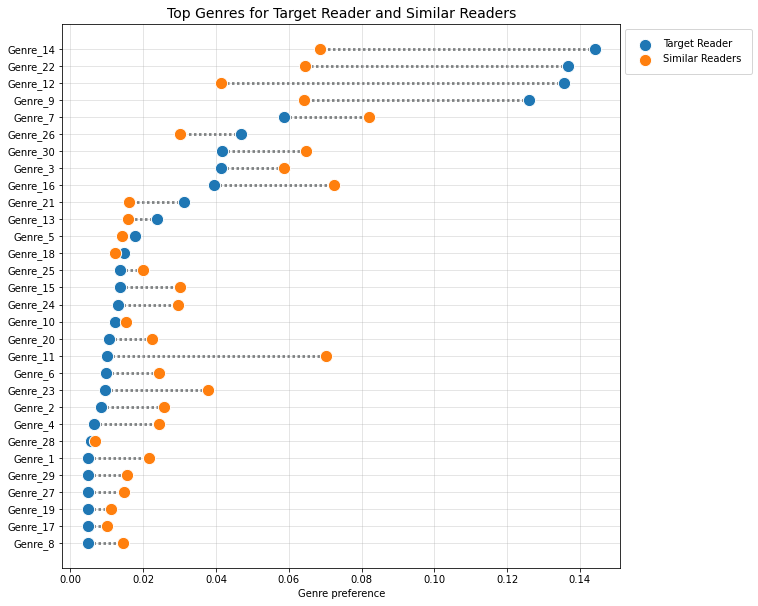

In [105]:
# Show top genres
plot_top_genres(svd_neighborhood_ratings, target_user_ratings)

In [106]:
# View most popular books among neighbors
popular_recs = neighbors_most_popular(svd_neighborhood_ratings, 50, min_ratings=400, write_to_excel=False)
popular_recs.head(15)

,title,avg_rating,ratings_count,year,percent_similar_users_read,url
66,Bad Feminist,3.91,43988.0,2014,1.6%,https://www.goodreads.com/book/show/18813642-b...
48,"Angels & Demons (Robert Langdon, #1)",3.86,2046499.0,2006,1.3%,https://www.goodreads.com/book/show/960.Angels...
681,"The Pillars of the Earth (Kingsbridge, #1)",4.29,471990.0,2002,1.1%,https://www.goodreads.com/book/show/5043.The_P...
835,"Wool Omnibus (Silo, #1)",4.24,83601.0,2012,1.1%,https://www.goodreads.com/book/show/13453029-w...
631,The Hundred Thousand Kingdoms (Inheritance Tri...,3.81,30194.0,2010,1.1%,https://www.goodreads.com/book/show/6437061-th...
616,The Golem and the Jinni (The Golem and the Jin...,4.10,61387.0,2013,1.0%,https://www.goodreads.com/book/show/15819028-t...
669,The New Jim Crow: Mass Incarceration in the Ag...,4.49,24694.0,2010,0.7%,https://www.goodreads.com/book/show/6792458-th...
477,Shoe Dog: A Memoir by the Creator of NIKE,4.44,27468.0,2016,0.7%,https://www.goodreads.com/book/show/27220736-s...
492,Sounds Like Me: My Life (So Far) in Song,4.26,3867.0,2015,0.7%,https://www.goodreads.com/book/show/25434361-s...
291,"I, Robot (Robot #0.1)",4.17,201196.0,2004,0.7%,https://www.goodreads.com/book/show/41804.I_Robot


In [107]:
# Highest rated books among similar readers
top_rated = neighbors_top_rated(svd_neighborhood_ratings, min_ratings=400, write_to_excel=False)
top_rated.head(15)

,title,avg_rating,ratings_count,year,url
456,Saga: Book One,4.70,4201.0,2014,https://www.goodreads.com/book/show/22078240-saga
467,Secrets of a Side Bitch 4,4.60,838.0,2015,https://www.goodreads.com/book/show/24518739-s...
33,"A Voice in the Wind (Mark of the Lion, #1)",4.59,57014.0,1993,https://www.goodreads.com/book/show/95617.A_Vo...
150,David Bowie Is...,4.59,423.0,2013,https://www.goodreads.com/book/show/15842729-d...
770,Topaz,4.59,875.0,1997,https://www.goodreads.com/book/show/1371133.Topaz
466,Secrets of a Side Bitch 3,4.58,1181.0,2014,https://www.goodreads.com/book/show/20934376-s...
566,"The Cartel (The Cartel, #1)",4.58,5703.0,2009,https://www.goodreads.com/book/show/5953477-th...
683,The Power of Vulnerability: Teachings of Authe...,4.57,3778.0,2013,https://www.goodreads.com/book/show/23500254-t...
465,Secrets of a Side Bitch 2,4.54,1419.0,2013,https://www.goodreads.com/book/show/18781068-s...
498,Stamped from the Beginning: The Definitive His...,4.54,996.0,2016,https://www.goodreads.com/book/show/25898216-s...


In [112]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    svd_neighborhood_ratings, 
    preds=top_preds, 
    how="MF", 
    whose_genres="target", 
    n_genres=5, 
    min_score=4.0, 
    min_ratings=400, 
    n_recs=20,
    write_to_excel=False
)

Genre 14: ['political', 'history', 'world', 'economic', 'government', 'global', 'politics', 'social', 'country', 'financial']


,title,avg_rating,ratings_count,url
170,Robert Oppenheimer: A Life Inside the Center,4.09,434.0,https://www.goodreads.com/book/show/12041966-r...
190,La guerra del fin del mundo,4.21,440.0,https://www.goodreads.com/book/show/139022.La_...
261,Utopia for Realists: Why Making the World a Be...,4.20,707.0,https://www.goodreads.com/book/show/32856013-u...
268,Superforecasting: The Art and Science of Predi...,4.13,4876.0,https://www.goodreads.com/book/show/23995360-s...
278,Kafka: Toward a Minor Literature,4.19,1058.0,https://www.goodreads.com/book/show/22913.Kafka
310,Narconomics: How to Run a Drug Cartel,4.14,2268.0,https://www.goodreads.com/book/show/25159062-n...
381,Capital in the Twenty-First Century,4.02,13494.0,https://www.goodreads.com/book/show/18736925-c...
415,Boyd: The Fighter Pilot Who Changed the Art of...,4.35,2025.0,https://www.goodreads.com/book/show/38840.Boyd
416,Dealers of Lightning: Xerox PARC and the Dawn ...,4.13,1054.0,https://www.goodreads.com/book/show/1101290.De...
541,The Silk Roads: A New History of the World,4.25,3022.0,https://www.goodreads.com/book/show/25812847-t...


_____

Genre 22: ['history', 'poem', 'text', 'introduction', 'writing', 'science', 'translation', 'literature', 'essay', 'modern']


,title,avg_rating,ratings_count,url
97,Labyrinths: Selected Stories and Other Writings,4.46,20553.0,https://www.goodreads.com/book/show/17717.Laby...
198,The Complete Stories and Poems,4.37,161550.0,https://www.goodreads.com/book/show/23919.The_...
201,Surprised by Scripture: Engaging Contemporary ...,4.06,618.0,https://www.goodreads.com/book/show/18651961-s...
209,Billions & Billions: Thoughts on Life and Deat...,4.26,11033.0,https://www.goodreads.com/book/show/61665.Bill...
238,Robot Dreams (Robot #0.4),4.13,6994.0,https://www.goodreads.com/book/show/41818.Robo...
256,What Is Life? with Mind and Matter and Autobio...,4.14,2817.0,https://www.goodreads.com/book/show/162780.Wha...
288,"Faraday, Maxwell, and the Electromagnetic Fiel...",4.24,431.0,https://www.goodreads.com/book/show/18240286-f...
342,"Surely You're Joking, Mr. Feynman!",4.29,1352.0,https://www.goodreads.com/book/show/17364.Sure...
365,"The Bible, the Qur'an, and Science: The Holy S...",4.06,814.0,https://www.goodreads.com/book/show/679675.The...
389,The Library of Babel,4.47,3929.0,https://www.goodreads.com/book/show/172366.The...


_____

Genre 12: ['alien', 'planet', 'world', 'human', 'space', 'war', 'galaxy', 'race', 'ship', 'humanity']


,title,avg_rating,ratings_count,url
102,"I, Robot (Robot, #0.1)",4.17,2235.0,https://www.goodreads.com/book/show/76684.I_Robot
103,"We Are Legion (We Are Bob) (Bobiverse, #1)",4.30,609.0,https://www.goodreads.com/book/show/32603222-w...
195,The Interstellar Age: Inside the Forty-Year Vo...,4.03,405.0,https://www.goodreads.com/book/show/22571516-t...
215,Spillover: Animal Infections and the Next Huma...,4.27,2586.0,https://www.goodreads.com/book/show/13637215-s...
411,The Ultimate Hitchhiker's Guide to the Galaxy,4.38,225626.0,https://www.goodreads.com/book/show/13.The_Ult...
734,Intentional Dissonance,4.09,571.0,https://www.goodreads.com/book/show/16153306-i...
759,Heir to the Empire (Star Wars: The Thrawn Tril...,4.12,51211.0,https://www.goodreads.com/book/show/216443.Hei...
915,The Last Rhinos: My Battle to Save One of the ...,4.34,1094.0,https://www.goodreads.com/book/show/13167157-t...
990,"Configured (Configured, #1)",4.20,905.0,https://www.goodreads.com/book/show/32065903-c...
1417,The Evolutionary Void,4.26,13729.0,https://www.goodreads.com/book/show/7438179-th...


_____

Genre 9: ['war', 'history', 'account', 'family', 'year', 'young', 'world', 'time', 'memoir', 'portrait']


,title,avg_rating,ratings_count,url
142,Winter Journey,4.03,892.0,https://www.goodreads.com/book/show/2035785.Wi...
160,The Operator: Firing the Shots that Killed Osa...,4.42,833.0,https://www.goodreads.com/book/show/34127824-t...
216,"The Grand Slam: Bobby Jones, America, and the ...",4.34,432.0,https://www.goodreads.com/book/show/1167728.Th...
337,We Wish to Inform You That Tomorrow We Will Be...,4.29,19564.0,https://www.goodreads.com/book/show/11472.We_W...
350,The Wall,4.07,12523.0,https://www.goodreads.com/book/show/10031.The_...
414,Mossad: The Greatest Missions of the Israeli S...,4.13,2673.0,https://www.goodreads.com/book/show/13623874-m...
473,"A Suitable Boy (A Suitable Boy, #1)",4.10,34468.0,https://www.goodreads.com/book/show/50365.A_Su...
477,"Wolf by Wolf (Wolf by Wolf, #1)",4.28,9710.0,https://www.goodreads.com/book/show/24807186-w...
483,Burning the Days: Recollection,4.07,520.0,https://www.goodreads.com/book/show/174628.Bur...
490,My Song: A Memoir,4.09,455.0,https://www.goodreads.com/book/show/12535150-m...


_____

Genre 7: ['film', 'music', 'funny', 'movie', 'hilarious', 'year', 'memoir', 'world', 'time', 'star']


,title,avg_rating,ratings_count,url
243,The Real James Herriot: A Memoir of My Father,4.17,3791.0,https://www.goodreads.com/book/show/38737.The_...
258,The Way I Am,4.30,1576.0,https://www.goodreads.com/book/show/3295736-th...
263,How to Be a Bawse: A Guide to Conquering Life,4.22,4319.0,https://www.goodreads.com/book/show/31202835-h...
360,Shooting an Elephant,4.11,5920.0,https://www.goodreads.com/book/show/30557.Shoo...
447,In the Garden of the North American Martyrs,4.15,1706.0,https://www.goodreads.com/book/show/54510.In_t...
457,A Million Miles in a Thousand Years: What I Le...,4.18,19224.0,https://www.goodreads.com/book/show/1999475.A_...
555,You Deserve a Drink: Boozy Misadventures and T...,4.21,4938.0,https://www.goodreads.com/book/show/23281915-y...
722,This is the Story of a Happy Marriage,4.03,13538.0,https://www.goodreads.com/book/show/17349222-t...
745,The Getaway Car: A Practical Memoir About Writ...,4.14,1446.0,https://www.goodreads.com/book/show/12471186-t...
787,My Voice,4.28,403.0,https://www.goodreads.com/book/show/28967446-m...


_____



### 2.3 Matrix Factorization with Gradient Descent

In [89]:
# Choose neighborhood size for GD
gd_neighborhoodhood_ratings = lg_neighborhoodhood_ratings

In [90]:
# Get unique users and books to slice df_reviews
gd_neighborhood_index = gd_neighborhoodhood_ratings["uid"].unique()
gd_neighborhood_index = np.append(gd_neighborhood_index, target)
gd_neighborhood_book_index = gd_neighborhoodhood_ratings["book_index"].unique()
gd_neighborhood_book_index = np.append(gd_neighborhood_book_index, target_user_ratings["book_index"].unique())
print(f"Neighborhood contains {gd_neighborhood_book_index.shape[0]} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, gd_neighborhood_book_index]
R = R[gd_neighborhood_index, :]
R = R.toarray()

Neighborhood contains 6289 books


In [28]:
# Function to train embedding matrices using alternating least squares (ALS) and make predictions 
def matrix_factorization(R, k_components=5, steps=4000, lr=0.0002, beta=0.03, decay=True, verbose=0):
    """
    Uses gradient descent to train matrix factorization algorithm

    Args:
        R: Utility matrix of user item ratings         
        k: Number of latent features
        steps: Number of epochs to run training
        lr: Learning rate
        beta: Regularization strength
        verbose: Prints updates if 1

    Returns:
        Predictions, User Embeddings, Item Embdeddings
    """

    # Initialize random values for user (P) and book (Q) embedding matrices    
    P = np.random.rand(R.shape[0],k_components)
    Q = np.random.rand(R.shape[1],k_components).T

    # Get nonzero ratings to perform operations on
    r_0 = np.where(R > 0) # Find indices where rating > 0
    i = r_0[0] # Get row indices where rating > 0
    j = r_0[1] # Get column indices where rating > 0 
    nonzero_ratings = R[i,j]

    # For each step calc residual and take step down gradient
    for step in range(steps): 
        resid = nonzero_ratings - (P @ Q)[i,j] # residual is value - r_hat       
        for k in range(k_components): # for each component (latent feature)                
            P[i,k] = P[i,k] + lr * (2 * resid * Q[k,j] - beta * P[i,k]) # Update P by step in gradient                             
            Q[k,j] = Q[k,j] + lr * (2 * resid * P[i,k] - beta * Q[k,j]) # Update Q by step in gradient            

        # Calculate error every n steps                  
        if ((step + 1) % 1000 == 0) | (step == 0): 
            error = 0 # Initialize counter for error  
            error = error + np.sum(pow(resid, 2)) # Add to error
            for k in range(k_components): # for each component (latent feature)                             
                error = error + (beta/2) * np.sum(pow(P[i,k],2) + pow(Q[k,j],2)) # Add regularized term            

            # View progress
            if verbose == 1:
                print(f"Step: {step + 1}, error: {error:.2f}, lr: {lr:.5f}") 
            
            # Set learning rate to decay until 0.00002
            if decay == True:
                if lr > 0.00002:                                
                    lr = lr / 2
    
    # Get predictions
    preds = np.dot(P, Q)

    return preds, P, Q.T

In [29]:
# Train model and get predictions
preds, user_embed, item_embed = matrix_factorization(
                                    R, 
                                    k_components=80, 
                                    lr=0.009, 
                                    beta=0.07,
                                    decay=True, 
                                    steps=8000, 
                                    verbose=1
                                )
df_preds_GD = pd.DataFrame(preds, columns=gd_neighborhood_book_index, index=gd_neighborhood_index)\
                .reset_index()

Step: 1, error: 2590829.32, lr: 0.00900
Step: 1000, error: 13564.89, lr: 0.00450
Step: 2000, error: 9212.79, lr: 0.00225
Step: 3000, error: 8023.68, lr: 0.00112
Step: 4000, error: 7589.60, lr: 0.00056
Step: 5000, error: 7405.01, lr: 0.00028
Step: 6000, error: 7320.01, lr: 0.00014
Step: 7000, error: 7279.24, lr: 0.00007
Step: 8000, error: 7259.28, lr: 0.00004


In [30]:
# View top predicted ratings
top_preds_GD = get_recs(df_preds_GD, target, book_index, df_books, write_to_excel=False)
top_preds_GD[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
                .query("avg_rating > 4 & ratings_count > 400").head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
0,The Women of Brewster Place,4.13,6.024167,14927.0,1983,https://www.goodreads.com/book/show/765811.The...
1,Atlas of Remote Islands,4.24,5.856601,1807.0,2010,https://www.goodreads.com/book/show/8197735-at...
3,Come As You Are: The Story of Nirvana,4.03,5.761546,6859.0,1993,https://www.goodreads.com/book/show/104961.Com...
7,The Little Book of Skin Care: Korean Beauty Se...,4.05,5.726867,1056.0,2015,https://www.goodreads.com/book/show/25066118-t...
8,The Book on the Taboo Against Knowing Who You Are,4.28,5.666711,10108.0,1989,https://www.goodreads.com/book/show/60551.The_...
11,The Course of Love,4.01,5.651096,7488.0,2016,https://www.goodreads.com/book/show/27845690-t...
12,"Spin (Spin, #1)",4.01,5.609199,26520.0,2006,https://www.goodreads.com/book/show/910863.Spin
13,Fermat's Enigma: The Epic Quest to Solve the W...,4.22,5.566096,16113.0,1998,https://www.goodreads.com/book/show/38412.Ferm...
15,Mink River,4.15,5.528053,3508.0,2010,https://www.goodreads.com/book/show/9250050-mi...
16,The Shining / Salems Lot / Night Shift / Carrie,4.64,5.517943,1400.0,1981,https://www.goodreads.com/book/show/5416.The_S...


In [31]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    gd_neighborhoodhood_ratings, 
    preds=top_preds_GD, 
    how="MF", 
    whose_genres="target", 
    n_genres=10, 
    min_score=4.0, 
    min_ratings=400, 
    n_recs=20,
    write_to_excel=False
)

Genre 14: ['political', 'history', 'world', 'economic', 'government', 'global', 'politics', 'social', 'country', 'financial']


,title,avg_rating,ratings_count,url
57,When Life Nearly Died: The Greatest Mass Extin...,4.12,708.0,https://www.goodreads.com/book/show/616394.Whe...
91,Ratf**ked: The True Story Behind The Secret Pl...,4.16,438.0,https://www.goodreads.com/book/show/26889647-r...
133,Disney War,4.02,2845.0,https://www.goodreads.com/book/show/414096.Dis...
140,From #blacklivesmatter To Black Liberation,4.54,548.0,https://www.goodreads.com/book/show/25330220-f...
149,Ego Is the Enemy,4.12,11380.0,https://www.goodreads.com/book/show/27036528-e...
182,"Indonesia, Etc.: Exploring the Improbable Nation",4.18,470.0,https://www.goodreads.com/book/show/18377963-i...
187,Our Revolution: A Future to Believe In,4.29,2430.0,https://www.goodreads.com/book/show/31741420-o...
247,Prisoners of Geography: Ten Maps That Explain ...,4.25,984.0,https://www.goodreads.com/book/show/29430757-p...
308,Diplomacy,4.18,4584.0,https://www.goodreads.com/book/show/781183.Dip...
371,Shades of Grey,4.14,23122.0,https://www.goodreads.com/book/show/2113260.Sh...


_____

Genre 22: ['history', 'poem', 'text', 'introduction', 'writing', 'science', 'translation', 'literature', 'essay', 'modern']


,title,avg_rating,ratings_count,url
13,Fermat's Enigma: The Epic Quest to Solve the W...,4.22,16113.0,https://www.goodreads.com/book/show/38412.Ferm...
37,"Surely You're Joking, Mr. Feynman!",4.29,1352.0,https://www.goodreads.com/book/show/17364.Sure...
77,Muhammad: His Life Based on the Earliest Sources,4.56,6837.0,https://www.goodreads.com/book/show/144925.Muh...
104,Van Gogh: The Life,4.09,14046.0,https://www.goodreads.com/book/show/10677213-v...
134,Guns,4.17,3687.0,https://www.goodreads.com/book/show/17284577-guns
139,The Glory of Their Times: The Story of the Ear...,4.32,3025.0,https://www.goodreads.com/book/show/461749.The...
156,The Bridge,4.15,693.0,https://www.goodreads.com/book/show/75495.The_...
158,Textbook Amy Krouse Rosenthal,4.23,1651.0,https://www.goodreads.com/book/show/27833861-t...
166,Felicity,4.27,2390.0,https://www.goodreads.com/book/show/24611522-f...
171,On Becoming a Novelist,4.09,1991.0,https://www.goodreads.com/book/show/32532.On_B...


_____

Genre 12: ['alien', 'planet', 'world', 'human', 'space', 'war', 'galaxy', 'race', 'ship', 'humanity']


,title,avg_rating,ratings_count,url
172,The Hyperion Omnibus: Hyperion / The Fall of H...,4.41,2254.0,https://www.goodreads.com/book/show/3943.The_H...
343,Enemy Mine,4.14,675.0,https://www.goodreads.com/book/show/1534509.En...
394,The Interstellar Age: Inside the Forty-Year Vo...,4.03,405.0,https://www.goodreads.com/book/show/22571516-t...
470,"K-Pax (K-Pax, #1)",4.09,1547.0,https://www.goodreads.com/book/show/1006596.K_Pax
486,The Empire Strikes Back,4.11,9048.0,https://www.goodreads.com/book/show/77111.The_...
630,Understand,4.22,869.0,https://www.goodreads.com/book/show/7234685-un...
651,Heir to the Empire (Star Wars: The Thrawn Tril...,4.12,51211.0,https://www.goodreads.com/book/show/216443.Hei...
652,Judas Unchained,4.30,21306.0,https://www.goodreads.com/book/show/45244.Juda...
719,Foundation / Foundation and Empire / Second Fo...,4.35,3316.0,https://www.goodreads.com/book/show/278097.Fou...
760,The Tartar Steppe,4.13,5025.0,https://www.goodreads.com/book/show/83017.The_...


_____

Genre 9: ['war', 'history', 'account', 'family', 'year', 'young', 'world', 'time', 'memoir', 'portrait']


,title,avg_rating,ratings_count,url
32,There are No Children Here: The Story of Two B...,4.25,10474.0,https://www.goodreads.com/book/show/41918.Ther...
65,Slouching Towards Bethlehem,4.23,18540.0,https://www.goodreads.com/book/show/424.Slouch...
116,Scheisshaus Luck: Surviving the Unspeakable in...,4.09,1049.0,https://www.goodreads.com/book/show/3930572-sc...
137,"America's Women: 400 Years of Dolls, Drudges, ...",4.15,2941.0,https://www.goodreads.com/book/show/137675.Ame...
155,Stars Between the Sun and Moon: One Woman's Li...,4.16,451.0,https://www.goodreads.com/book/show/25420166-s...
183,The Complete Poems,4.05,7337.0,https://www.goodreads.com/book/show/223394.The...
196,An Autobiography,4.34,4332.0,https://www.goodreads.com/book/show/125441.An_...
203,Agaat,4.05,868.0,https://www.goodreads.com/book/show/7105495-agaat
208,Beneath a Scarlet Sky,4.43,16505.0,https://www.goodreads.com/book/show/32487617-b...
227,The Lost Wife,4.20,1852.0,https://www.goodreads.com/book/show/12877358-t...


_____

Genre 7: ['film', 'music', 'funny', 'movie', 'hilarious', 'year', 'memoir', 'world', 'time', 'star']


,title,avg_rating,ratings_count,url
3,Come As You Are: The Story of Nirvana,4.03,6859.0,https://www.goodreads.com/book/show/104961.Com...
51,Tranny: Confessions of Punk Rock's Most Infamo...,4.23,2655.0,https://www.goodreads.com/book/show/29467305-t...
86,Love Her Wild: Poems,4.22,1691.0,https://www.goodreads.com/book/show/33208115-l...
118,Humans of New York: Stories,4.50,12833.0,https://www.goodreads.com/book/show/24019187-h...
122,We Are Never Meeting In Real Life,4.02,4864.0,https://www.goodreads.com/book/show/33381433-w...
135,Cool Gray City of Love: 49 Views of San Francisco,4.22,848.0,https://www.goodreads.com/book/show/16059425-c...
194,Crazy Is My Superpower: How I Triumphed by Br...,4.48,551.0,https://www.goodreads.com/book/show/27866300-c...
220,The Best of the Best: 20 Years of the Year's B...,4.16,552.0,https://www.goodreads.com/book/show/98045.The_...
222,Peter and Alice,4.44,561.0,https://www.goodreads.com/book/show/17347724-p...
224,Out on the Wire: Uncovering the Secrets of Rad...,4.19,627.0,https://www.goodreads.com/book/show/23742836-o...


_____

Genre 26: ['war', 'king', 'throne', 'family', 'young', 'world', 'royal', 'court', 'power', 'kingdom']


,title,avg_rating,ratings_count,url
21,"My Lady Jane (The Lady Janies, #1)",4.12,14458.0,https://www.goodreads.com/book/show/22840421-m...
24,When Christ and His Saints Slept (Henry II an...,4.27,10892.0,https://www.goodreads.com/book/show/43841.When...
121,The Beast's Garden,4.03,822.0,https://www.goodreads.com/book/show/23702432-t...
480,Perfect State,4.07,8253.0,https://www.goodreads.com/book/show/25188109-p...
561,"Lame Deer, Seeker of Visions",4.25,1345.0,https://www.goodreads.com/book/show/226354.Lam...
626,Pachinko,4.18,8161.0,https://www.goodreads.com/book/show/29983711-p...
639,"Shogun, Part 1",4.54,4585.0,https://www.goodreads.com/book/show/12319445-s...
669,"Dancer's Lament (Path to Ascendancy, #1)",4.45,1085.0,https://www.goodreads.com/book/show/25480364-d...
795,"The Potato Factory (The Potato Factory, #1)",4.07,6773.0,https://www.goodreads.com/book/show/137808.The...
876,"Scythe (Arc of a Scythe, #1)",4.30,13000.0,https://www.goodreads.com/book/show/28954189-s...


_____

Genre 30: ['world', 'young', 'family', 'place', 'fiction', 'time', 'year', 'journey', 'house', 'dark']


,title,avg_rating,ratings_count,url
0,The Women of Brewster Place,4.13,14927.0,https://www.goodreads.com/book/show/765811.The...
15,Mink River,4.15,3508.0,https://www.goodreads.com/book/show/9250050-mi...
23,The Peregrine,4.18,1040.0,https://www.goodreads.com/book/show/1071726.Th...
66,Well-Read Women: Portraits of Fiction's Most B...,4.30,861.0,https://www.goodreads.com/book/show/17557474-w...
193,Underground: Finding the Light to Freedom,4.05,931.0,https://www.goodreads.com/book/show/9663849-un...
307,Manto: Selected Stories,4.13,543.0,https://www.goodreads.com/book/show/7518598-manto
390,What It Means When a Man Falls from the Sky,4.18,1624.0,https://www.goodreads.com/book/show/31522415-w...
498,Ocean Sea,4.13,5825.0,https://www.goodreads.com/book/show/208631.Oce...
595,Asterios Polyp,4.19,20053.0,https://www.goodreads.com/book/show/4070095-as...
623,Castle of Water,4.32,491.0,https://www.goodreads.com/book/show/29939086-c...


_____

Genre 3: ['spiritual', 'faith', 'people', 'experience', 'church', 'way', 'world', 'question', 'personal', 'wisdom']


,title,avg_rating,ratings_count,url
8,The Book on the Taboo Against Knowing Who You Are,4.28,10108.0,https://www.goodreads.com/book/show/60551.The_...
11,The Course of Love,4.01,7488.0,https://www.goodreads.com/book/show/27845690-t...
19,The Hole in Our Gospel: What does God expect o...,4.18,9789.0,https://www.goodreads.com/book/show/5291189-th...
55,"Purification of the Heart: Signs, Symptoms and...",4.49,2078.0,https://www.goodreads.com/book/show/272724.Pur...
64,Every Body Yoga: Let Go of Fear. Get On the Ma...,4.34,619.0,https://www.goodreads.com/book/show/30754069-e...
69,Why Gender Matters: What Parents and Teachers ...,4.03,1637.0,https://www.goodreads.com/book/show/24355.Why_...
96,The Prayer That Changes Everything: The Hidden...,4.50,999.0,https://www.goodreads.com/book/show/375836.The...
142,"Far from the Tree: Parents, Children, and the ...",4.27,12131.0,https://www.goodreads.com/book/show/13547504-f...
159,Loving God,4.31,1342.0,https://www.goodreads.com/book/show/903912.Lov...
179,The Art of Happiness,4.14,63653.0,https://www.goodreads.com/book/show/38210.The_...


_____

Genre 16: ['guide', 'help', 'health', 'technique', 'way', 'practical', 'advice', 'people', 'business', 'learn']


,title,avg_rating,ratings_count,url
7,The Little Book of Skin Care: Korean Beauty Se...,4.05,1056.0,https://www.goodreads.com/book/show/25066118-t...
54,6 Months to 6 Figures,4.07,915.0,https://www.goodreads.com/book/show/23702503-6...
56,Just Listen: Discover the Secret to Getting Th...,4.10,3846.0,https://www.goodreads.com/book/show/6547576-ju...
95,Vegan for Life: Everything You Need to Know to...,4.11,1179.0,https://www.goodreads.com/book/show/9848914-ve...
98,How We Do Harm: A Doctor Breaks Ranks About Be...,4.13,1021.0,https://www.goodreads.com/book/show/12085010-h...
191,Doing It!: Let's Talk About Sex,4.17,1126.0,https://www.goodreads.com/book/show/32181998-d...
199,The Thinking Woman's Guide to a Better Birth,4.13,2782.0,https://www.goodreads.com/book/show/11394.The_...
270,Your Deceptive Mind: A Scientific Guide to Cri...,4.30,1005.0,https://www.goodreads.com/book/show/13562148-y...
311,The Law of Attraction: The Basics of the Teach...,4.15,13522.0,https://www.goodreads.com/book/show/343614.The...
313,Thinking in Systems: A Primer,4.24,3011.0,https://www.goodreads.com/book/show/3828902-th...


_____

Genre 21: ['mission', 'die', 'team', 'terrorist', 'agent', 'war', 'military', 'spy', 'pa', 'au']


,title,avg_rating,ratings_count,url
629,"First to Kill (Nathan McBride, #1)",4.04,1897.0,https://www.goodreads.com/book/show/3931026-fi...
1138,Building a Character,4.14,611.0,https://www.goodreads.com/book/show/178213.Bui...
2650,The Shadow of Saganami (Honorverse: Saganami I...,4.12,4684.0,https://www.goodreads.com/book/show/77745.The_...
3463,The Demon in the Freezer,4.10,8213.0,https://www.goodreads.com/book/show/198505.The...
4931,"The Eagle Has Landed (Liam Devlin, #1)",4.15,42409.0,https://www.goodreads.com/book/show/295961.The...
5366,Killing the Rising Sun: How America Vanquished...,4.37,6260.0,https://www.goodreads.com/book/show/29370481-k...
5632,The Trident Deception (Trident Deception #1),4.09,565.0,https://www.goodreads.com/book/show/17934508-t...
5666,"The B-Team (The Human Division, #1)",4.06,3986.0,https://www.goodreads.com/book/show/16180352-t...
5748,"Power Down (Dewey Andreas, #1)",4.17,8179.0,https://www.goodreads.com/book/show/8495956-po...
5793,"Orphan X (Orphan X, #1)",4.08,11229.0,https://www.goodreads.com/book/show/25663888-o...


_____

